In [1]:
import psycopg2
from psycopg2 import sql
import pandas as pd
from datetime import datetime

In [27]:
# Old DB
POSTGRES_ADDRESS = "51.138.75.249"
POSTGRES_PASSWORD = ""
POSTGRES_USERNAME = ""
DATABSE_NAME = "tsdb"

class OldDB:
    def __init__(self):
        self.db_params = {
                            'host': POSTGRES_ADDRESS,
                            'port': '5432',
                            'database': 'tsdb',
                            'user': POSTGRES_USERNAME,
                            'password': POSTGRES_PASSWORD
                        }
        
        self.conn = psycopg2.connect(**self.db_params)
        self.cursor = self.conn.cursor()
        self.errors = 0

    def run_query(self, query):

        if self.cursor.closed:
            self.cursor = self.conn.cursor()

        self.cursor.execute(query)
        self.conn.commit()
        results = self.cursor.fetchall()
        self.cursor.close()
        return results

    def format_results(self, results):
        df = pd.DataFrame(results, columns=['time', 'direction', 'sensor_name', 'last_5min_sum'])
        df['time'] = pd.to_datetime(df['time'])
        return df

    def create_query(self, table_name, date):
        query = f"select time, direction, sensor_name, last_5min_sum from {table_name} where date(time) = '{date}'"
        return query

    def close(self):
        self.conn.close()

In [28]:
old_db = OldDB()

In [29]:
# date range from one month back to today
date_range = pd.date_range(end=datetime.today(), periods=30).to_pydatetime().tolist()
date_range = [date.strftime("%Y-%m-%d") for date in date_range]
date_range[:2]

['2023-09-07', '2023-09-08']

In [34]:
res = []
for date in date_range:
    query = old_db.create_query('passings' ,date)
    print(query)
    result = old_db.run_query(query)
    df = old_db.format_results(result)
    res.append(df)

old_db.close()
df = pd.concat(res)

select time, direction, sensor_name, last_5min_sum from passings where date(time) = '2023-09-07'
select time, direction, sensor_name, last_5min_sum from passings where date(time) = '2023-09-08'
select time, direction, sensor_name, last_5min_sum from passings where date(time) = '2023-09-09'
select time, direction, sensor_name, last_5min_sum from passings where date(time) = '2023-09-10'
select time, direction, sensor_name, last_5min_sum from passings where date(time) = '2023-09-11'
select time, direction, sensor_name, last_5min_sum from passings where date(time) = '2023-09-12'
select time, direction, sensor_name, last_5min_sum from passings where date(time) = '2023-09-13'
select time, direction, sensor_name, last_5min_sum from passings where date(time) = '2023-09-14'
select time, direction, sensor_name, last_5min_sum from passings where date(time) = '2023-09-15'
select time, direction, sensor_name, last_5min_sum from passings where date(time) = '2023-09-16'
select time, direction, sensor

In [38]:
df.to_feather('passings.feather')


In [2]:
df = pd.read_feather('passings.feather')

<Axes: xlabel='time'>

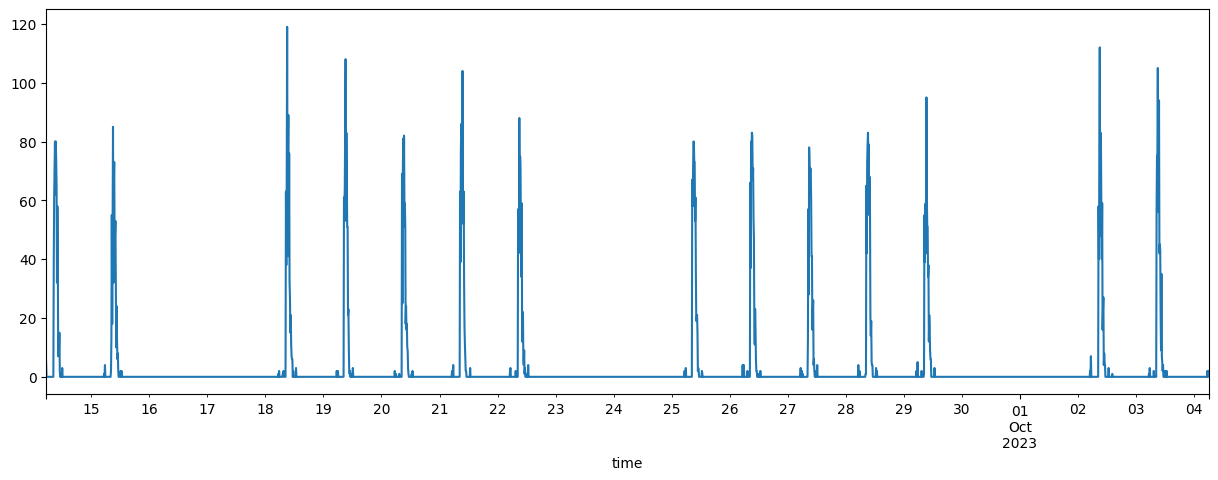

In [3]:
df[df.sensor_name == 'inngang1'].set_index('time')['direction'].resample('10T').count().plot(figsize=(15,5))

In [4]:
# Old DB
POSTGRES_ADDRESS = "kantine.postgres.database.azure.com"
POSTGRES_PASSWORD = ""
POSTGRES_USERNAME = ""
DATABSE_NAME = "tsdb"

class NewDB:
    def __init__(self):
        self.db_params = {
                            'host': POSTGRES_ADDRESS,
                            'port': '5432',
                            'database': 'tsdb',
                            'user': POSTGRES_USERNAME,
                            'password': POSTGRES_PASSWORD
                        }
        
        self.conn = psycopg2.connect(**self.db_params)
        self.cursor = self.conn.cursor()
        self.errors = 0

    def run_query(self, query):

        if self.cursor.closed:
            self.cursor = self.conn.cursor()

        self.cursor.execute(query)
        self.conn.commit()
        results = self.cursor.fetchall()
        self.cursor.close()
        return results

    def insert_data(self, data_to_insert, query):
        try:
            
            if self.cursor.closed:
                self.cursor = self.conn.cursor()

            # Define the SQL query to insert data into the hypertable
            insert_query = sql.SQL(query)
            
            # Loop through the data and insert each row
            for row in data_to_insert:
                self.cursor.execute(insert_query, row)
            
            # Commit the changes to the database
            self.conn.commit()
            
            # Close the cursor and the connection
            self.cursor.close()

        except psycopg2.Error as e:
            print(f"Error: {e}")
            self.errors += 1
            if self.errors > 10:
                AssertionError("Too many errors")         

    def insert_data_passings(self, data_to_insert):

            # Define the SQL query to insert data into the hypertable
            query = """
                INSERT INTO passings (time, direction, sensor_name, last_5min_sum)
                VALUES (%s, %s, %s, %s)
            """
                
            self.insert_data(data_to_insert, query)                   

    def create_cursor(self):
        return self.conn.cursor()
    
    def close_cursor(self):
        self.cursor.close()

    def close_connection(self):
        self.conn.close()

    def __del__(self):
        self.close_cursor()
        self.close_connection()

In [12]:
df.reset_index(inplace=True)
df[df.time == '2023-09-21T09:17:48+00:00']

,index,time,direction,sensor_name,last_5min_sum
7492,631,2023-09-21 09:17:48+00:00,IN,inngang1,10
7493,632,2023-09-21 09:17:48+00:00,IN,Inngang2,9


In [7]:
from tqdm import tqdm

In [13]:
new_db = NewDB()
for i, row in enumerate(tqdm(df.itertuples(index=False), total=df.shape[0])):
    if i > 7492: 
        time = row.time
        direction = row.direction
        sensor_name = row.sensor_name
        last_5min_sum = row.last_5min_sum
        new_db.insert_data_passings([(time, direction, sensor_name, last_5min_sum)])

100%|██████████| 19627/19627 [32:57<00:00,  9.93it/s]  
